# Improved EDA on Kepler Objects of Interest Dataset
***Matt Paterson, hello@hireMattPaterson.com***<br>
**General Assembly, DSI-12, 2020**


This notebook reads in a ready-to-run dataset from NASA's Kepler Objects of Interest dataset. In this notebook we take the raw data and try to find what is needed for a more accurate predictive model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import lebowski, my custom Python Library for EDA
import lebowski as dude
# import autoreload in case I create new lebowski funcitons
import autoreload  

# Libraries needed for Logistic Regression and RandomForestClassifier

from sklearn.linear_model        import LogisticRegression
from sklearn.ensemble            import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection     import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing       import StandardScaler
from sklearn                     import metrics

# Libraries needed for Recurrent Neural Network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path_to_home = '../'
datapath = path_to_home + 'data/'

In [3]:
df = pd.read_csv(datapath + 'dirty_kepler.csv')
df.head()

,kepid,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,12168280,2,0,0,0,0,229.957537,0.006730,-0.006730,326.01840,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
1,11923074,0,0,0,0,1,1.756471,0.000015,-0.000015,132.02757,...,-157.0,4.561,0.033,-0.176,0.833,0.227,-0.071,296.14072,50.279949,14.723
2,11867733,0,0,1,0,0,384.356448,0.003680,-0.003680,298.90354,...,-193.0,4.445,0.067,-0.202,0.994,0.291,-0.125,293.77362,50.124470,14.391
3,10585887,0,1,0,0,0,378.654840,0.022800,-0.022800,288.25840,...,-209.0,4.463,0.070,-0.210,0.970,0.306,-0.123,285.24338,47.812592,14.872
4,10532751,0,1,0,0,0,367.761848,0.006750,-0.006750,194.76970,...,-295.0,2.897,0.045,-0.014,9.888,0.257,-2.058,290.87155,47.753368,10.736


## Do the flags indicate the planet's disposition?

Recall that koi_disposition equals 0 for 'Fals Positive', or not an exoplanet, 1 for 'Confirmed' as an exoplanet, or 2 for 'Candidate'. We want to eliminate columns in the dataset that will be harmful to prediction and create columns that might prove more helpful.

What do the four flag columns say about the kisposition column?


In [4]:
flags = ['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

In [5]:
df[flags].groupby('koi_disposition').sum()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
koi_disposition,,,,
0,1135,2106,1779,1093
1,466,14,0,0
2,1,2,0,0


We see that the majority of the observations that contain flags have been deemed to not be exoplanets. Only 3 of 2245 observations that are still candidates have any flags at all.

In [6]:
df['koi_disposition'].value_counts()

0    4214
1    2285
2    2245
Name: koi_disposition, dtype: int64

In [7]:
df[flags].corr()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
koi_disposition,1.000000,-0.021399,-0.523012,-0.472108,-0.353074
koi_fpflag_nt,-0.021399,1.000000,-0.020494,-0.002847,0.002204
koi_fpflag_ss,-0.523012,-0.020494,1.000000,0.145303,0.088528
koi_fpflag_co,-0.472108,-0.002847,0.145303,1.000000,0.531398
koi_fpflag_ec,-0.353074,0.002204,0.088528,0.531398,1.000000


The above table shows the correlation between each flag and the koi_disposition...and each other. Below we can see a heatmap visualization of the same.

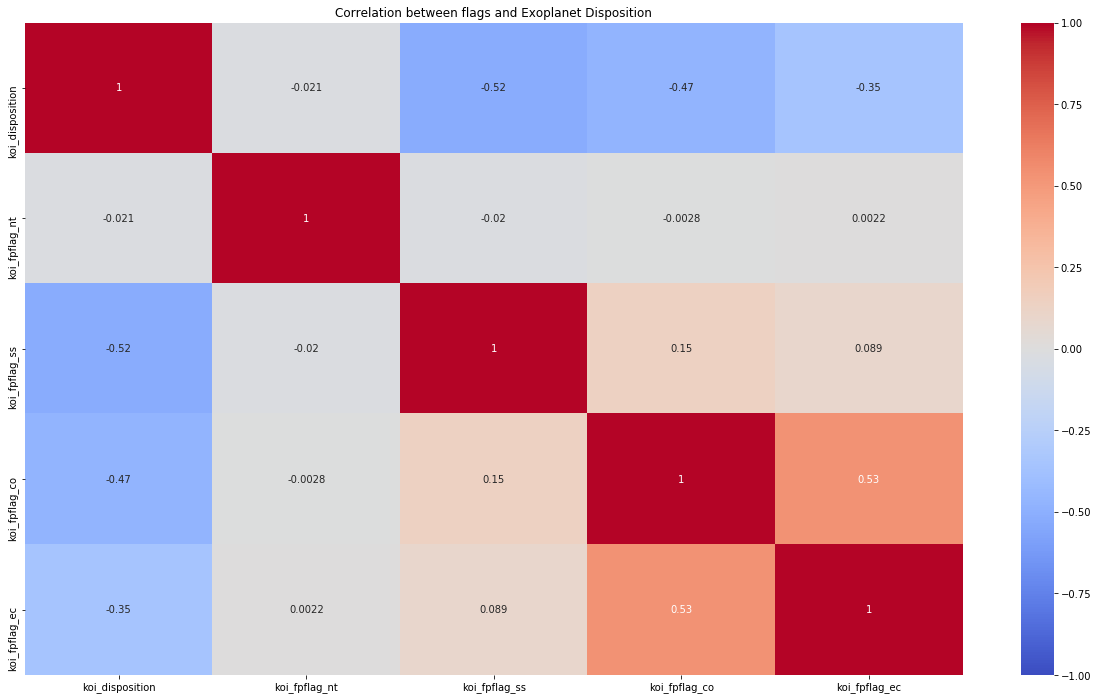

In [8]:
dude.heatmap_this(df, flags, 'Correlation between flags and Exoplanet Disposition')

Here we can see a fairly strong positive correlation between koi_fpflag_co and koi_fpflag_ec, and an equally strong negative correlation between koi_fpflag_ss and koi_disposition.

_co and _ec stand for Centroid Offset Flag and Ephemeris Match Indicates Contamination Flag respectively.

_ss stands for Stellar Eclipse Flag.

The Stellar Eclipse Flag is set for observations that have been deemed to have been caused by some sort of eclipse of the star that is most likely caused by another star.  This is why the negative correlation is so strong, because it is a column marked by the researchers to weed out false positives in their initial candidate field.

The other two are indicators of anomalies in the data resulting from errors in the technology.

To conclude, we'll delete all of the flag columns becuase they are used by the researchers that compiled this dataset to idicate whether or not they had found the expolanets. They are instructive to us to see why each observation was labled, but will not help our algorithm to label future data that have zero's in these fields.

In [9]:
flags.remove('koi_disposition')

In [10]:
df = df.drop(columns=flags)

In [11]:
df.shape

(8744, 38)

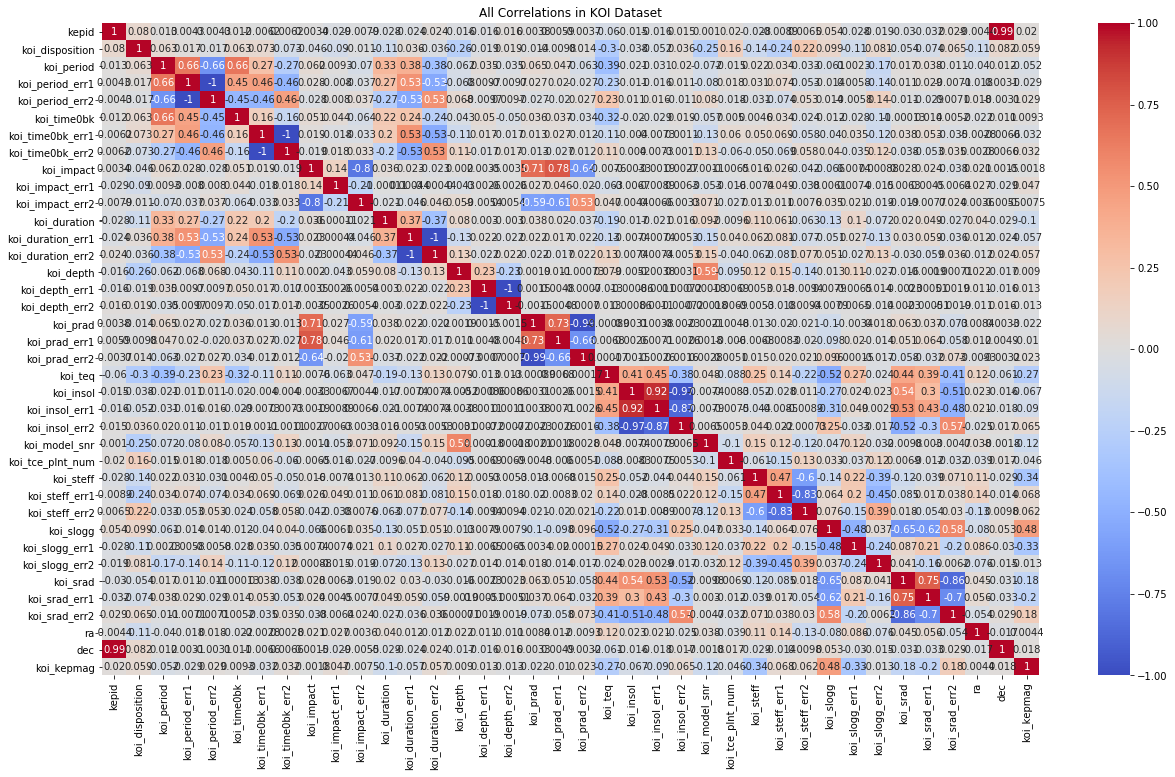

In [12]:
dude.heatmap_this(df=df, features=df.columns, title='All Correlations in KOI Dataset')

Now it looks like none of the remaining columns have a strong positive or negative correlation to the koi_disposition, or its likelihood of being an expolanet or not.

Let's make the index the kepid and cut out the candidates and see if that changes anything.

In [13]:
df.set_index('kepid', inplace=True)

In [14]:
candidates = df[df['koi_disposition'] == 2]
candidates.head()

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
kepid,,,,,,,,,,,,,,,,,,,,,
12168280,2,229.957537,0.006730,-0.006730,326.01840,0.01510,-0.01510,1.175,74.310,-4.203,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
9592621,2,191.037280,0.013200,-0.013200,153.91070,0.06480,-0.06480,0.091,0.456,-0.091,...,-180.0,4.497,0.055,-0.165,0.901,0.213,-0.091,293.68390,46.265541,16.652
9159288,2,66.673050,0.012400,-0.012400,161.59000,0.17600,-0.17600,0.415,0.049,-0.415,...,-256.0,4.369,0.072,-0.217,1.190,0.404,-0.135,293.68979,45.549332,14.634
9011955,2,367.089600,0.022800,-0.022800,178.67440,0.04220,-0.04220,1.242,72.990,-3.631,...,-260.0,4.429,0.058,-0.232,1.100,0.384,-0.128,287.86737,45.321289,15.267
8673511,2,0.757261,0.000004,-0.000004,131.62154,0.00472,-0.00472,0.322,0.190,-0.321,...,-171.0,4.479,0.062,-0.200,0.953,0.279,-0.093,284.29565,44.895859,14.024


In [15]:
df = df[df['koi_disposition'] != 2] 

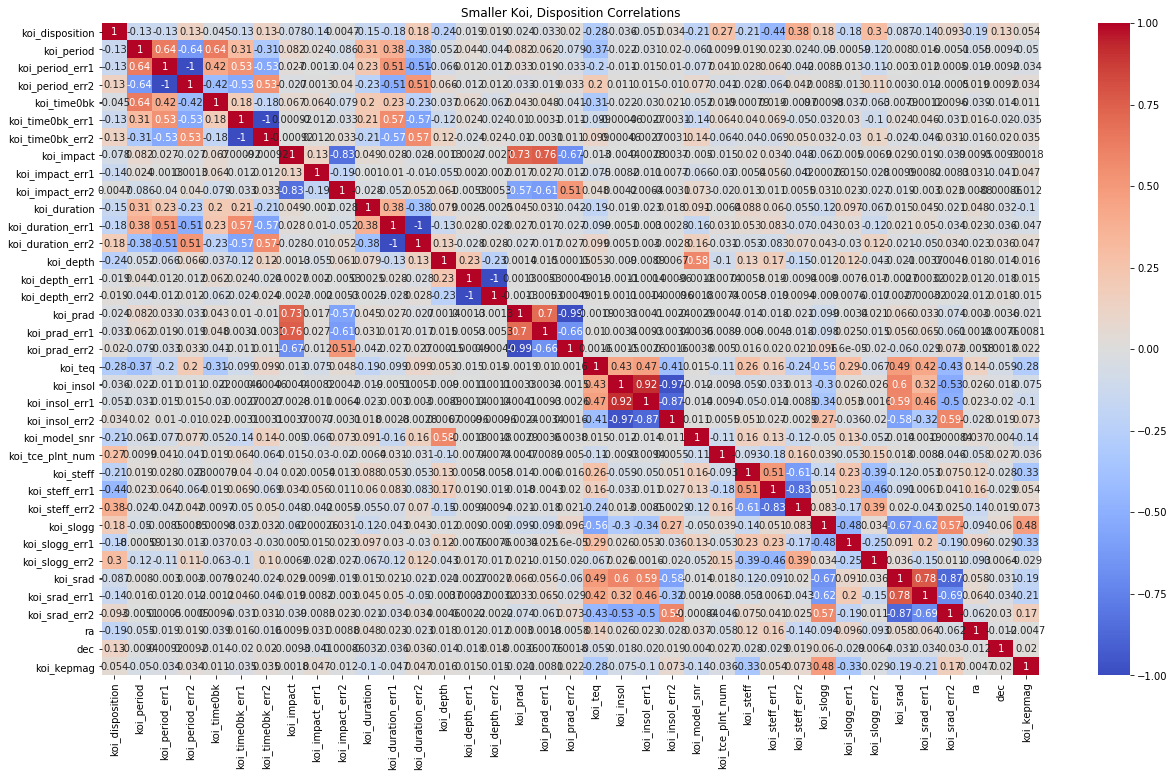

In [16]:
dude.heatmap_this(df, df.columns, 'Smaller Koi, Disposition Correlations')

There are still no strong correlations showing here. Can we throw these in a model and see what comes out?

In [17]:
#### This function is useful, save it in lebowski.py and use below

# def kepler_data_split(dataframe):
#     '''
#     Employs the train_test_split function and the StandardScalar() as well
    
#     '''
#     X = dataframe.drop(columns='koi_disposition')
#     y = dataframe['koi_disposition']

#     X_train, X_val, y_train, y_val = train_test_split(X, y,
#                                                       test_size = .2, 
#                                                       random_state = 42, 
#                                                       stratify=y)

#     sc = StandardScaler()
#     X_train_sc = sc.fit_transform(X_train)
#     X_val_sc = sc.transform(X_val)
    
#     return X_train, X_train_sc, X_val, X_val_sc, y_train, y_val

In [18]:
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = dude.scaled_data_split(dataframe=df, target='koi_disposition')

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train_sc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
print('Training Score: ', rf.score(X_train_sc, y_train))
print('Validation Score: ', rf.score(X_val_sc, y_val))

Training Score:  1.0
Validation Score:  0.9407692307692308


It's still mind boggling that this RandomForestClassifier can be so accurate when there are no strong data correlations in the original dataset. We should look at the confusion matrix and see what we see.

In [21]:
y_pred = rf.predict(X_val_sc)

In [23]:
metrics.confusion_matrix(y_val, y_pred, 
                         normalize=None)

array([[806,  37],
       [ 40, 417]], dtype=int64)

In [29]:
# This code improved from Matt Brems lesson in General Assembly
tn, fp, fn, tp = metrics.confusion_matrix(y_val, y_pred).ravel()
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))
print()
print("False Positives: " + str(fp))
print("True Positives: " + str(tp))


True Negatives: 806
False Negatives: 40

False Positives: 37
True Positives: 417


In [31]:
sensitivity = tp / (tp+fn)
print(f'Sensitivity : {sensitivity}')
specificity = tn / (tn+fp)
print(f'Specificity : {specificity}')

Sensitivity : 0.912472647702407
Specificity : 0.9561091340450771


We can see that the model did a pretty good job at predicting our ground truth, with a Sensitivity of 91.2%, and a Specificity of 95.6%.

For the sake of assuredness, I can even weight these predictions when I'm more sure of the model, so that I have a lower number--even zero--of false positives. This way, I might miss some exoplanets, but I won't falsely predict any.

In [24]:
ss = StandardScaler()

Fit the candidates data to the Standard Scaler

In [25]:
test = candidates.drop(columns='koi_disposition')

In [32]:
ss.fit(X_train)
test_sc = ss.transform(test)

In [33]:
candidates['exoplanet'] = rf.predict(test_sc)

In [34]:
candidates.exoplanet.value_counts()

0    1435
1     810
Name: exoplanet, dtype: int64

If this model is predicting accurately, we have just identified 738 new exoplanets, given that our model predicted 810 out of 2245 observations to be exoplanets and has a sensitivity of 91.2%

## Create RNN part 2
In an earlier iteration, we created a recurrent neural network on our dirty data. How will the RNN preform on the new data?

In [35]:
X_train_sc.shape

(5199, 36)

In [36]:
# Use the same RNN that we built prior as a "baseline", 
# but change the first layer to have the same number of 
# nodes as input features

rnn = Sequential()
rnn.add(Dense(36, input_dim=X_train.shape[1], activation='relu'))
rnn.add(Dense(16, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc']) # loss = 'bce'

history_rnn = rnn.fit(
    X_train_sc,
    y_train,
    validation_data=(X_val_sc, y_val),
    epochs=100,
    batch_size=None,
    verbose=2
)

Epoch 1/100
163/163 - 0s - loss: 0.4880 - acc: 0.7917 - val_loss: 0.3257 - val_acc: 0.8646
Epoch 2/100
163/163 - 0s - loss: 0.2941 - acc: 0.8854 - val_loss: 0.2386 - val_acc: 0.9046
Epoch 3/100
163/163 - 0s - loss: 0.2393 - acc: 0.9081 - val_loss: 0.2109 - val_acc: 0.9138
Epoch 4/100
163/163 - 0s - loss: 0.2115 - acc: 0.9192 - val_loss: 0.1952 - val_acc: 0.9269
Epoch 5/100
163/163 - 0s - loss: 0.1938 - acc: 0.9248 - val_loss: 0.1862 - val_acc: 0.9300
Epoch 6/100
163/163 - 0s - loss: 0.1806 - acc: 0.9323 - val_loss: 0.1820 - val_acc: 0.9338
Epoch 7/100
163/163 - 0s - loss: 0.1716 - acc: 0.9359 - val_loss: 0.1755 - val_acc: 0.9385
Epoch 8/100
163/163 - 0s - loss: 0.1625 - acc: 0.9367 - val_loss: 0.1688 - val_acc: 0.9385
Epoch 9/100
163/163 - 0s - loss: 0.1597 - acc: 0.9396 - val_loss: 0.1701 - val_acc: 0.9392
Epoch 10/100
163/163 - 0s - loss: 0.1541 - acc: 0.9433 - val_loss: 0.1603 - val_acc: 0.9400
Epoch 11/100
163/163 - 0s - loss: 0.1488 - acc: 0.9448 - val_loss: 0.1623 - val_acc: 0.94

Epoch 91/100
163/163 - 0s - loss: 0.0739 - acc: 0.9740 - val_loss: 0.1581 - val_acc: 0.9477
Epoch 92/100
163/163 - 0s - loss: 0.0714 - acc: 0.9742 - val_loss: 0.1548 - val_acc: 0.9469
Epoch 93/100
163/163 - 0s - loss: 0.0748 - acc: 0.9733 - val_loss: 0.1620 - val_acc: 0.9462
Epoch 94/100
163/163 - 0s - loss: 0.0729 - acc: 0.9754 - val_loss: 0.1678 - val_acc: 0.9462
Epoch 95/100
163/163 - 0s - loss: 0.0729 - acc: 0.9740 - val_loss: 0.1582 - val_acc: 0.9446
Epoch 96/100
163/163 - 0s - loss: 0.0727 - acc: 0.9740 - val_loss: 0.1624 - val_acc: 0.9469
Epoch 97/100
163/163 - 0s - loss: 0.0736 - acc: 0.9744 - val_loss: 0.1696 - val_acc: 0.9431
Epoch 98/100
163/163 - 0s - loss: 0.0752 - acc: 0.9708 - val_loss: 0.1608 - val_acc: 0.9423
Epoch 99/100
163/163 - 0s - loss: 0.0721 - acc: 0.9742 - val_loss: 0.1593 - val_acc: 0.9431
Epoch 100/100
163/163 - 0s - loss: 0.0709 - acc: 0.9736 - val_loss: 0.1586 - val_acc: 0.9454


In [37]:
# base code From Matt Brems, Tim Book, and Justin Pounders
# improved by Matt Paterson
def display_metrics(model_name, metric):
    train_loss = model_name.history[metric]
    test_loss = model_name.history['val_' + metric]

    plt.figure(figsize=(12, 8))
    plt.plot(train_loss, label='Training ' + metric, color='navy')
    plt.plot(test_loss, label='Validation val_' + metric, color='fuchsia')
    plt.legend();

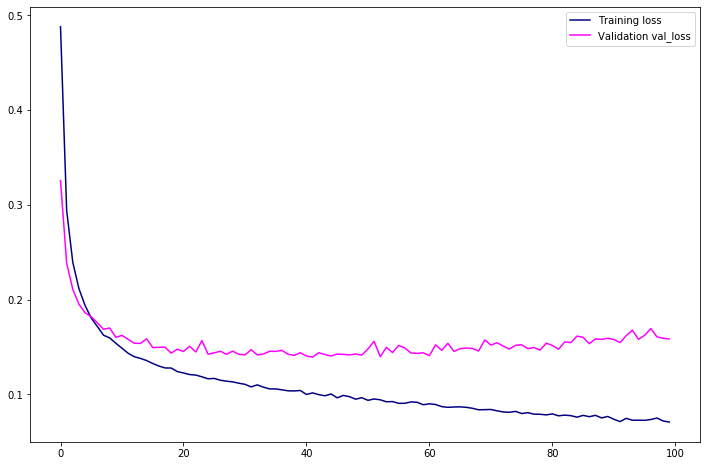

In [39]:
display_metrics(history_rnn, 'loss')

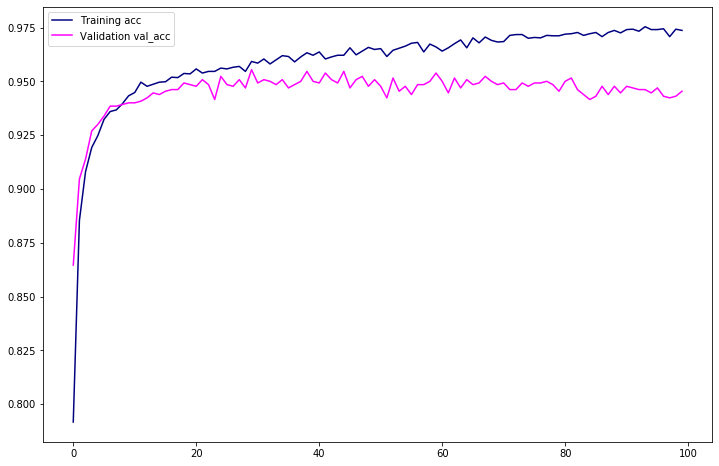

In [40]:
display_metrics(history_rnn, 'acc')

In [43]:
model_rnn_top_score = sorted(history_rnn.history['val_acc'], reverse=True)[0]
print(f'This model has a maximum accuracy score of {model_rnn_top_score}')

model_rnn_best_loss = sorted(history_rnn.history['val_loss'], reverse=False)[0]
print(f'This model has a minimum loss score of {model_rnn_best_loss}')

This model has a maximum accuracy score of 0.9553846120834351
This model has a minimum loss score of 0.13940581679344177


In [44]:
candidates['exoplanet_rnn'] = rnn.predict(test_sc)

In [47]:
candidates['exoplanet_rnn'].value_counts()

0.000000e+00    10
9.882761e-01     2
2.522469e-04     2
8.805847e-02     1
1.184382e-07     1
                ..
1.318523e-02     1
2.512142e-02     1
2.330877e-01     1
1.419878e-02     1
5.847532e-02     1
Name: exoplanet_rnn, Length: 2234, dtype: int64

Need to break for now, but we can see that the rnn model is not predicting 1's and 0's for some reason in the last cell?